## Exercise 1– BABY NAMES BY STATE and YEAR

In [1]:
# Import the libraries needed
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

In [71]:
class BabyNames:
    """A class that demonstrates the patterns in baby names by state over the years.
    """
    
   
    def __init__(self, path):
        """Initiate instances by reading from files and concatenating them into dataframes
        """
    
        all_files = glob.glob(os.path.join(path, "*.TXT"))
        dframes = []
        for item in all_files:
            data = pd.read_csv(item,header=None,names=['state','gender','year','name','count'])
            dframes.append(data)
        self.df = pd.concat(dframes, axis=0, ignore_index=True)
   
   
    def Count(self, state=None, year=None):
        """Count the total number of births at a certain state and year. Empty state means all, same for year.
        """
        
        if state == None and year == None:
            return sum(self.df["count"])
        if state == None:
            return self.df[self.df["year"] == year].sum()["count"]
        if year == None:
            return self.df[self.df["state"] == state].sum()["count"]
        return self.df[(self.df["year"] == year) & (self.df["state"] == state)]["count"].sum()
    
    def Top10BabyNames(self, state=None, year=None):
        """Return a dataframe showing the top 10 baby names for a certain state and year. Empty state means all, same for year.
        """
        
        # Select the rows corresponding to state and year
        if state == None and year == None:
            df_state_year = self.df
        elif state == None:
            df_state_year = self.df[self.df["year"] == year]
        elif year == None:
            df_state_year = self.df[self.df["state"] == state]
        else:
            df_state_year = self.df[(self.df["year"] == year) & (self.df["state"] == state)]
        
        # Calculate the total number of births for each name used by different genders 
        df_sum = df_state_year.groupby(["gender", "name"]).sum()["count"].to_frame().reset_index()
        
        # Sort the values based on number of births and assign a rank
        df_rank = df_sum.assign(rank = df_sum.groupby("gender")["count"].rank("first", ascending = False)).\
                                sort_values("rank").head(20).pivot(index = "rank", columns = "gender", values = "name").reset_index()
        
        # Rename the columns 
        df_rank.columns = ["Rank", "Female", "Male"]
        return df_rank
    
    def ChangeOfPopularity(self, fromYear, toYear, top):
        """Print baby names(male or female) showing change in popularity as follows:
            i.Names that increased most in popularity.
            ii.Names that decreased most in popularity.
            iii.The most popular names that had the same popularity  
        """
        
        # Select the data we need from the whole table and reshape it
        df_change = self.df[(self.df["year"] == fromYear) | (self.df["year"] == toYear)].groupby(["name","year"]).\
                        sum()["count"].to_frame().reset_index().pivot(index = "name", columns = "year", values = "count").fillna(0)
        
        # Calculate the difference of count bwtween toYear and fromYear
        df_change["change"] = df_change[toYear] - df_change[fromYear]
        
        # Print the results
        print("Top" + str(top) + "names that increased in popularity:")
        print(df_change.sort_values("change", ascending = False).head(top))
        print("Top" + str(top) + "names that decreased in popularity:")
        print(df_change.sort_values("change").head(top))
        print("Top" + str(top) + "names having the same popularity:")
        print(df_change[df_change["change"] == 0].sort_values(fromYear, ascending = False).head(top))

    def Top5NamesPerYear(self, year, sex=None):
        """Return a dataframe showing the top 5 names for the corresponding year and sex. 
        """
        
        # Select the data we need from the whole dataframe
        if sex == None:
            df_year = self.df[self.df["year"] == year]
        else:
            df_year = self.df[(self.df["year"] == year) & (self.df["gender"] == sex)].groupby(["state","name"])\
                                                                            .sum()["count"].to_frame().reset_index()
            
        # Select the top 5 names for each state
        df_top5 = df_year.sort_values("count", ascending = False).groupby("state").head(5)
        df_top5 = df_top5.assign(rank = df_top5.groupby("state")["count"].rank(method = "first",ascending = False)).\
                                    pivot(index = "state", columns = "rank", values = ["name", "count"]).stack(0).unstack()
        df_top5 = df_top5[[(1.0, "name"),(1.0, "count"),(2.0, "name"),(2.0, "count"),\
                                (3.0, "name"),(3.0, "count"),(4.0, "name"),(4.0, "count"),\
                                (5.0, "name"),(5.0, "count")]]
        return df_top5

        

    def NamePopularityPlot(self, name, yearRange, state, sex):
        """Create a plot that shows the name popularity changes over the year. 
        Popularity is based on the proportional use of the name within a state and year.
        """
        
        # Select the data of the state and years we need
        df_state = self.df[self.df["state"] == state]
        proportion_list = []
        for year in yearRange:
            df_state_year = df_state[df_state["year"] == year]
            total = df_state_year.sum()["count"]
            popularity_count = df_state_year[(df_state_year["name"] == name) & (df_state_year["gender"] == sex)]["count"].values
            
            # If no corresponding count for a certain year and state, then the popularity is 0
            if len(popularity_count) == 0:
                popularity = 0
            else:
                popularity = popularity_count[0]
            proportion_list.append(popularity/total)
            
        # Plot the changes 
        plt.plot(yearRange, proportion_list, "o-")
        
    def NameFlip(self, n=10):
        """A flip is defined as a name used to be mostly used by a certain gender and then became mostly used by the 
        other gender in the following year. The function returns the baby names that flip most often during the years.
        """
        # Calculate the number of births based on name, year and gender 
        df_flip = self.df.groupby(["name","year", "gender"]).sum()["count"].to_frame().unstack("gender").fillna(0)
        df_flip.columns = df_flip.columns.droplevel()
        
        # Create a column showing the dominant gender for a name
        df_flip["gen_dom"] = ["F" if female else "M" for female in df_flip["F"] > df_flip["M"]]
        df_flip = df_flip[df_flip["F"] != df_flip["M"]]
        
        #Drop the rows where the numbers of male and female are the same.
        df_flip["gen_dom_shift"] = df_flip.groupby("name")["gen_dom"].shift().fillna(df_flip["gen_dom"])
        
        # Calculate the total number of flips for a name 
        df_flip["flip"] = [1 if flip else 0 for flip in df_flip["gen_dom"] != df_flip["gen_dom_shift"]]
        df_flip = df_flip.groupby("name").sum()["flip"].sort_values(ascending = False).head(10).to_frame().reset_index()
        df_flip.plot(kind = "bar", x ="name", y = "flip")
        return df_flip
       
    def NamePopularityPlotStory(self,name, yearRange,state,sex):
        
        if state != None:
            tmp_df = self.df[(self.df['name'] == name)&(self.df['year'].isin(list(range(yearRange[0],yearRange[1]))))&(self.df['state'] == state)&(self.df['gender']==sex)]
            tmp_df_full = self.df[(self.df['year'].isin(list(range(yearRange[0],yearRange[1]))))&(self.df['state'] == state)]
            tmp_df_full.rename(columns={"count":"total_count"},inplace=True)
            tmp_df_full_grpd = tmp_df_full.groupby('year').agg({'total_count':'sum'}).reset_index()
        else:
            tmp_df = self.df[(self.df['name'] == name)&(self.df['year'].isin(list(range(yearRange[0],yearRange[1]))))&(self.df['gender']==sex)]
            tmp_df = tmp_df.groupby('year').agg({"year":'first',"name":'first',"count":"sum"}).reset_index(drop=True)
            tmp_df_full = self.df[(self.df['year'].isin(list(range(yearRange[0],yearRange[1]))))]
            tmp_df_full.rename(columns={"count":"total_count"},inplace=True)
            tmp_df_full_grpd = tmp_df_full.groupby('year').agg({'total_count':'sum'}).reset_index()
        

        self.name_pop_df = pd.merge(tmp_df,tmp_df_full_grpd,how = 'inner',on='year')
        self.name_pop_df['pop_proportion'] = 100*(self.name_pop_df['count']/self.name_pop_df.total_count)
        
        ax=self.name_pop_df.plot('year','pop_proportion',kind='scatter',figsize=(12,10))
        ax.set(xlabel = 'Year',ylabel= 'Count of Babies Named {}/Total Number of Babies Born in the Year'.format(name))
        ax.set(title = 'Name Popularity Plot')
        
        return self.name_pop_df

In [72]:
baby = BabyNames("namesbystate")

In [73]:
baby.Count(state = "NY", year = 2000)

214844

In [74]:
baby.Top10BabyNames(year=2000)

,Rank,Female,Male
0,1.0,Emily,Jacob
1,2.0,Hannah,Michael
2,3.0,Madison,Matthew
3,4.0,Ashley,Joshua
4,5.0,Sarah,Christopher
5,6.0,Alexis,Nicholas
6,7.0,Samantha,Andrew
7,8.0,Jessica,Joseph
8,9.0,Elizabeth,Daniel
9,10.0,Taylor,Tyler


In [75]:
baby.ChangeOfPopularity(2015,2016,10)

Top10names that increased in popularity:
year          2015     2016  change
name                               
Adeline     2403.0   4112.0  1709.0
Charlotte  11390.0  13080.0  1690.0
Mateo       4999.0   6534.0  1535.0
Oliver     11649.0  13025.0  1376.0
Bryson      3092.0   4341.0  1249.0
Lincoln     6084.0   7212.0  1128.0
Riley       7808.0   8827.0  1019.0
Adaline      871.0   1857.0   986.0
Benjamin   13692.0  14629.0   937.0
Amelia      9852.0  10753.0   901.0
Top10names that decreased in popularity:
year          2015     2016  change
name                               
Logan      13708.0  12054.0 -1654.0
Jayden     11936.0  10446.0 -1490.0
Jacob      15943.0  14479.0 -1464.0
Mason      16662.0  15279.0 -1383.0
Sophia     17402.0  16112.0 -1290.0
Alexa       6031.0   4755.0 -1276.0
Ethan      15069.0  13806.0 -1263.0
Aiden      13467.0  12220.0 -1247.0
Alexander  14531.0  13388.0 -1143.0
Madison    10129.0   9023.0 -1106.0
Top10names having the same popularity:
year       2015

In [76]:
baby.Top5NamesPerYear(2015, "F")

rank        1.0              2.0              3.0              4.0        \
           name count       name count       name count       name count   
state                                                                      
AK       Olivia    56       Emma    49     Aurora    46        Ava    41   
AL          Ava   298       Emma   285     Olivia   260     Harper   214   
AR         Emma   214     Olivia   171        Ava   168   Isabella   135   
AZ       Sophia   474        Mia   464       Emma   450     Olivia   420   
CA       Sophia  2954        Mia  2861       Emma  2720     Olivia  2527   
CO         Emma   355     Olivia   347        Mia   254     Evelyn   251   
CT       Sophia   217       Emma   203     Olivia   201   Isabella   186   
DC      Genesis    50  Charlotte    47        Ava    47      Sofia    45   
DE          Ava    69     Olivia    59     Sophia    57    Abigail    48   
FL     Isabella  1380       Emma  1224     Sophia  1176     Olivia  1156   
GA          Ava   634     Olivia   562       Emma   541    Madison   444   
HI          Mia    73       Emma    67     Olivia    62       Aria    59   
IA         Emma   199     Olivia   192     Harper   183     Evelyn   142   
ID       Olivia   116       Emma   113     Evelyn    74        Ava    72   
IL       Olivia   815       Emma   810     Sophia   734        Mia   668   
IN         Emma   434     Olivia   413        Ava   382     Harper   334   
KS         Emma   215     Olivia   199     Harper   161        Ava   161   
KY         Emma   307     Olivia   272        Ava   254     Harper   230   
LA          Ava   323       Emma   294     Olivia   256   Isabella   193   
MA       Olivia   430       Emma   402     Sophia   373   Isabella   350   
MD       Olivia   321        Ava   308     Sophia   307       Emma   278   
ME         Emma    75     Olivia    68     Amelia    65    Abigail    55   
MI       Olivia   602        Ava   571       Emma   501     Sophia   420   
MN       Olivia   377       Emma   323     Evelyn   272        Ava   267   
MO         Emma   396     Olivia   379        Ava   326     Harper   299   
MS          Ava   214       Emma   165     Olivia   141    Madison   120   
MT         Emma    69     Olivia    58     Harper    53        Ava    47   
NC          Ava   624       Emma   582     Olivia   565   Isabella   431   
ND          Ava    71       Emma    70     Olivia    64     Harper    59   
NE       Olivia   121       Emma   120     Harper   117  Charlotte   109   
NH       Olivia    91  Charlotte    87       Emma    82     Sophia    66   
NJ         Emma   532     Sophia   518   Isabella   518     Olivia   503   
NM          Mia   122     Sophia   113   Isabella   103        Ava    97   
NV       Sophia   190     Olivia   173        Mia   170       Emma   159   
NY       Olivia  1297       Emma  1258     Sophia  1122   Isabella  1069   
OH         Emma   721        Ava   713     Olivia   693     Sophia   542   
OK         Emma   270     Olivia   243        Ava   189     Sophia   176   
OR         Emma   234     Olivia   219     Sophia   181    Abigail   170   
PA       Olivia   783       Emma   765        Ava   722     Sophia   595   
RI       Olivia    83       Emma    77     Sophia    74        Ava    64   
SC          Ava   280     Olivia   238       Emma   226    Madison   207   
SD       Harper    59       Emma    58     Olivia    51        Ava    46   
TN         Emma   476        Ava   415     Olivia   413     Harper   298   
TX         Emma  2203     Sophia  2176        Mia  2041   Isabella  1861   
UT         Emma   285     Olivia   281  Charlotte   192     Evelyn   160   
VA         Emma   466     Olivia   459        Ava   458  Charlotte   404   
VT         Emma    33        Ava    30     Harper    26  Charlotte    25   
WA       Olivia   478       Emma   421     Sophia   353        Ava   306   
WI         Emma   352     Olivia   348        Ava   262     Evelyn   262   
WV         Emma   143        Ava   108     Olivi

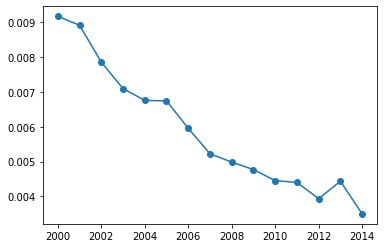

In [77]:
baby.NamePopularityPlot("Matthew", range(2000, 2015), "IL", "M")

,name,flip
0,Natividad,28
1,Pilar,22
2,Dell,21
3,Lorenza,20
4,Nieves,19
5,Michal,18
6,Salome,17
7,Baby,16
8,Nicola,16
9,Golden,15


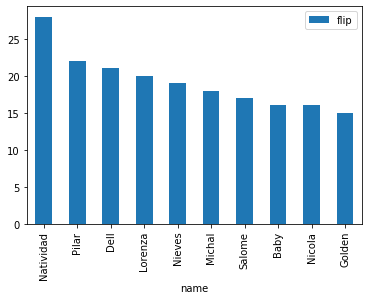

In [84]:
baby.NameFlip()

## Exercise 2 - Pandas

In [85]:
# Import libraries needed
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql

In [86]:
# Connect to mysql
cnx = pymysql.connect(user='root', \
      password='', \
      host= 'localhost', \
      port=3306, \
      db='world', \
      autocommit=True)

# Read the country table
df_country = pd.read_sql_query("select * from Country", con=cnx)

#### 1.  Find the top 10 countries which have the largest population and have a  population greater than 50000000. Rank them descendingly based on population. 
select *
<br>from country
<br>where population > 50000000
<br>order by population DESC limit 10

#### sql solution

In [87]:
df_p1_sql = pd.read_sql_query('select * from country where population > 50000000 order by population DESC limit 10',\
                              con=cnx)
df_p1_sql

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
0,CHN,China,Asia,Eastern Asia,9572900.0,-1523,1277558000,71.4,982268.0,917719.0,Zhongquo,People'sRepublic,Jiang Zemin,1891,CN
1,IND,India,Asia,Southern and Central Asia,3287263.0,1947,1013662000,62.5,447114.0,430572.0,Bharat/India,Federal Republic,Kocheril Raman Narayanan,1109,IN
2,USA,United States,North America,North America,9363520.0,1776,278357000,77.1,8510700.0,8110900.0,United States,Federal Republic,George W. Bush,3813,US
3,IDN,Indonesia,Asia,Southeast Asia,1904569.0,1945,212107000,68.0,84982.0,215002.0,Indonesia,Republic,Abdurrahman Wahid,939,ID
4,BRA,Brazil,South America,South America,8547403.0,1822,170115000,62.9,776739.0,804108.0,Brasil,Federal Republic,Fernando Henrique Cardoso,211,BR
5,PAK,Pakistan,Asia,Southern and Central Asia,796095.0,1947,156483000,61.1,61289.0,58549.0,Pakistan,Republic,Mohammad Rafiq Tarar,2831,PK
6,RUS,Russian Federation,Europe,Eastern Europe,17075400.0,1991,146934000,67.2,276608.0,442989.0,Rossija,Federal Republic,Vladimir Putin,3580,RU
7,BGD,Bangladesh,Asia,Southern and Central Asia,143998.0,1971,129155000,60.2,32852.0,31966.0,Bangladesh,Republic,Shahabuddin Ahmad,150,BD
8,JPN,Japan,Asia,Eastern Asia,377829.0,-660,126714000,80.7,3787042.0,4192638.0,Nihon/Nippon,Constitutional Monarchy,Akihito,1532,JP
9,NGA,Nigeria,Africa,Western Africa,923768.0,1960,111506000,51.6,65707.0,58623.0,Nigeria,Federal Republic,Olusegun Obasanjo,2754,NG


#### pandas solution

In [88]:
df_p1_pandas = df_country[df_country["Population"] > 50000000].sort_values(by = "Population", ascending = False).\
                                                                            head(10).reset_index(drop = True)
df_p1_pandas

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
0,CHN,China,Asia,Eastern Asia,9572900.0,-1523.0,1277558000,71.4,982268.0,917719.0,Zhongquo,People'sRepublic,Jiang Zemin,1891.0,CN
1,IND,India,Asia,Southern and Central Asia,3287263.0,1947.0,1013662000,62.5,447114.0,430572.0,Bharat/India,Federal Republic,Kocheril Raman Narayanan,1109.0,IN
2,USA,United States,North America,North America,9363520.0,1776.0,278357000,77.1,8510700.0,8110900.0,United States,Federal Republic,George W. Bush,3813.0,US
3,IDN,Indonesia,Asia,Southeast Asia,1904569.0,1945.0,212107000,68.0,84982.0,215002.0,Indonesia,Republic,Abdurrahman Wahid,939.0,ID
4,BRA,Brazil,South America,South America,8547403.0,1822.0,170115000,62.9,776739.0,804108.0,Brasil,Federal Republic,Fernando Henrique Cardoso,211.0,BR
5,PAK,Pakistan,Asia,Southern and Central Asia,796095.0,1947.0,156483000,61.1,61289.0,58549.0,Pakistan,Republic,Mohammad Rafiq Tarar,2831.0,PK
6,RUS,Russian Federation,Europe,Eastern Europe,17075400.0,1991.0,146934000,67.2,276608.0,442989.0,Rossija,Federal Republic,Vladimir Putin,3580.0,RU
7,BGD,Bangladesh,Asia,Southern and Central Asia,143998.0,1971.0,129155000,60.2,32852.0,31966.0,Bangladesh,Republic,Shahabuddin Ahmad,150.0,BD
8,JPN,Japan,Asia,Eastern Asia,377829.0,-660.0,126714000,80.7,3787042.0,4192638.0,Nihon/Nippon,Constitutional Monarchy,Akihito,1532.0,JP
9,NGA,Nigeria,Africa,Western Africa,923768.0,1960.0,111506000,51.6,65707.0,58623.0,Nigeria,Federal Republic,Olusegun Obasanjo,2754.0,NG


#### 2. Calculate the number of countries and the total population for each continent and rank them in alphabet order of continents.
select Continent, count(*) As Number_Countries, sum(population) As Population
<br>from country
<br>where population > 0
<br>group by Continent
<br>order by 1 ASC

#### sql solution

In [89]:
df_p2_sql = pd.read_sql_query('select Continent, count(*) As Number_Countries, sum(population) As Population \
                                from country \
                                where population > 0 \
                                group by Continent \
                                order by 1 ASC', con = cnx)
df_p2_sql

,Continent,Number_Countries,Population
0,Asia,51,3.705026e+09
1,Europe,46,7.300746e+08
2,North America,37,4.829930e+08
3,Africa,57,7.844750e+08
4,Oceania,27,3.040115e+07
5,South America,14,3.457800e+08


#### pandas solution

In [90]:
df_p2_pandas = df_country[df_country["Population"] > 0].groupby("Continent").agg({"Name": "size","Population": "sum"}).\
                                    rename(columns = {"Name": "Name_Countries"}).sort_values("Continent").reset_index()
df_p2_pandas

,Continent,Name_Countries,Population
0,Africa,57,784475000
1,Asia,51,3705025700
2,Europe,46,730074600
3,North America,37,482993000
4,Oceania,27,30401150
5,South America,14,345780000


#### 3. Find the top 10 cities in the United States which have the largest population
select city.Name As City, city.population
<br>from city
<br>inner join country ON city.CountryCode = country.code
<br>where country.code = 'USA'
<br>order by city.population DESC limit 10

In [91]:
df_city = pd.read_sql_query('select * from city', con=cnx,index_col='ID')

In [92]:
df_p3_sql = pd.read_sql_query('select city.Name As City, city.population \
                                from city \
                                inner join country ON city.CountryCode = country.code \
                                where country.code = "USA" \
                                order by city.population DESC limit 10', con = cnx)
df_p3_sql

,City,population
0,New York,8008278
1,Los Angeles,3694820
2,Chicago,2896016
3,Houston,1953631
4,Philadelphia,1517550
5,Phoenix,1321045
6,San Diego,1223400
7,Dallas,1188580
8,San Antonio,1144646
9,Detroit,951270


In [93]:
df_p3_pandas = df_city.merge(df_country.query("Code == 'USA'"), left_on = "CountryCode", right_on = "Code", \
                            how = "inner")[["Name_x","Population_x"]].rename(columns = {"Name_x":"City",\
                            "Population_x": "population"}).sort_values("population",ascending = False).head(10)
df_p3_pandas

,City,population
0,New York,8008278
1,Los Angeles,3694820
2,Chicago,2896016
3,Houston,1953631
4,Philadelphia,1517550
5,Phoenix,1321045
6,San Diego,1223400
7,Dallas,1188580
8,San Antonio,1144646
9,Detroit,951270


#### 4. Find the top 10 countries which have the most number of people speaking the official language of the country
select country.Name, Language, (Percentage * population) / 100
<br>from countrylanguage
<br>inner join country on countrylanguage.CountryCode = country.code
<br>where IsOfficial = True
<br>order by 3 DESC limit 10

In [94]:
df_countrylanguage = pd.read_sql_query('select * from countrylanguage', con=cnx)

In [95]:
df_p4_sql = pd.read_sql_query('select country.Name, Language, (Percentage * population) / 100 \
                                from countrylanguage \
                                inner join country on countrylanguage.CountryCode = country.code \
                                where IsOfficial = True \
                                order by 3 DESC limit 10',con=cnx)
df_p4_sql

,Name,Language,(Percentage * population) / 100
0,China,Chinese,1.175353e+09
1,India,Hindi,4.044512e+08
2,United States,English,2.399437e+08
3,Brazil,Portuguese,1.658621e+08
4,Russian Federation,Russian,1.272448e+08
5,Bangladesh,Bengali,1.261844e+08
6,Japan,Japanese,1.255736e+08
7,Mexico,Spanish,9.106940e+07
8,Germany,German,7.501637e+07
9,Vietnam,Vietnamese,6.929418e+07


In [96]:
df_p4_pandas = pd.merge(df_countrylanguage, df_country, left_on = "CountryCode", right_on = "Code", how = "inner").\
                        query("IsOfficial == 'T'").assign(pop = lambda x: x["Percentage"] * x["Population"]/100).\
                        rename(columns = {"pop": "(Percentage * population) / 100"})[["Name", "Language", \
                        "(Percentage * population) / 100"]].sort_values("(Percentage * population) / 100",\
                        ascending = False).head(10).reset_index(drop = True)
df_p4_pandas

,Name,Language,(Percentage * population) / 100
0,China,Chinese,1.175353e+09
1,India,Hindi,4.044511e+08
2,United States,English,2.399437e+08
3,Brazil,Portuguese,1.658621e+08
4,Russian Federation,Russian,1.272448e+08
5,Bangladesh,Bengali,1.261844e+08
6,Japan,Japanese,1.255736e+08
7,Mexico,Spanish,9.106940e+07
8,Germany,German,7.501637e+07
9,Vietnam,Vietnamese,6.929418e+07


#### 5. Find the top 5 languages used by most number of people 
select Language, sum((Percentage * population) / 100)
<br>from countrylanguage
<br>inner join country ON countrylanguage.CountryCode = country.code
<br>group by Language
<br>order by 2 desc limit 5

#### sql solution

In [97]:
df_p5_sql = pd.read_sql_query('select Language, sum((Percentage * population) / 100) \
                                from countrylanguage \
                                inner join country ON countrylanguage.CountryCode = country.code \
                                group by Language \
                                order by 2 desc limit 5', con=cnx)
df_p5_sql

,Language,sum((Percentage * population) / 100)
0,Chinese,1.191844e+09
1,Hindi,4.056331e+08
2,Spanish,3.550295e+08
3,English,3.470779e+08
4,Arabic,2.338392e+08


#### pandas solution

In [98]:
df_p5_pandas = pd.merge(df_countrylanguage, df_country, left_on = "CountryCode", right_on = "Code", how = "inner").\
                        assign(pop = lambda x: x["Percentage"] * x["Population"]/100).groupby("Language").\
                        agg({"pop":"sum"}).sort_values("pop", ascending = False).head(5).\
                        rename(columns = {"pop":"sum((Percentage * population) / 100)"}).reset_index()
df_p5_pandas

,Language,sum((Percentage * population) / 100)
0,Chinese,1.191844e+09
1,Hindi,4.056331e+08
2,Spanish,3.550295e+08
3,English,3.470779e+08
4,Arabic,2.338392e+08


## <font color='orange'> Exercise 3 Create a Story

The analysis shown below shows how US baby names trend with popular athelete names. Namely, they seem to spike at the early part of a superstar athletes career, peaking with in trend with the athlete's success.  However, if the athlete continues to dominate after their initial burst onto the scene, name trends tend to return to normal levels before the athlete became nationally famous. 

In this case of Kobe Bryant, he entered the NBA league in 1997 and you can see a significant spike in that name being used that year and it continues to rise as he began to dominate in the league betwee 2000-2003.  However there is a sharp drop off after 2003 and this might be linked to the fact that he arrersted on a sexual assault charge in mid-late 2003.

In the case of Serena Williams she entered the professional tennis scene in 1995 and you can see a significant surge in the usage of the name from that point through the year 2000. Serena was one of the most exciting players in tennis due to her being extremely young and her success/poise against the veterans in the tennis scene. However as she began to become one of the veteran's herself, while she continued to dominate, the usuage of the name began to reduce once again as the 'hype' factor was now reduced.

#### Kobe Bryant

C:\Users\pspat\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,year,name,count,total_count,pop_proportion
0,1996,Kobe,37,3225567,0.001147
1,1997,Kobe,304,3193822,0.009518
2,1998,Kobe,1093,3230178,0.033837
3,1999,Kobe,829,3234048,0.025634
4,2000,Kobe,1418,3297841,0.042998
5,2001,Kobe,1538,3252018,0.047294
6,2002,Kobe,1383,3238979,0.042699
7,2003,Kobe,1199,3290057,0.036443
8,2004,Kobe,594,3295289,0.018026
9,2005,Kobe,411,3306909,0.012429


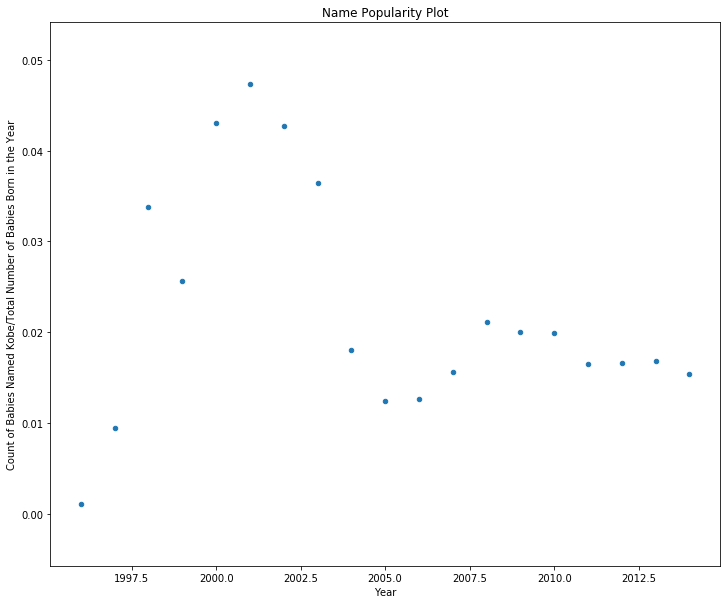

In [99]:
baby.NamePopularityPlotStory(name='Kobe', yearRange=(1990,2015), state=None, sex='M')

,year,name,count,total_count,pop_proportion
0,1990,Serena,409,3567015,0.011466
1,1991,Serena,453,3503086,0.012931
2,1992,Serena,437,3442568,0.012694
3,1993,Serena,490,3364306,0.014565
4,1994,Serena,567,3307657,0.017142
5,1995,Serena,796,3249717,0.024494
6,1996,Serena,889,3225567,0.027561
7,1997,Serena,1170,3193822,0.036633
8,1998,Serena,1382,3230178,0.042784
9,1999,Serena,1408,3234048,0.043537


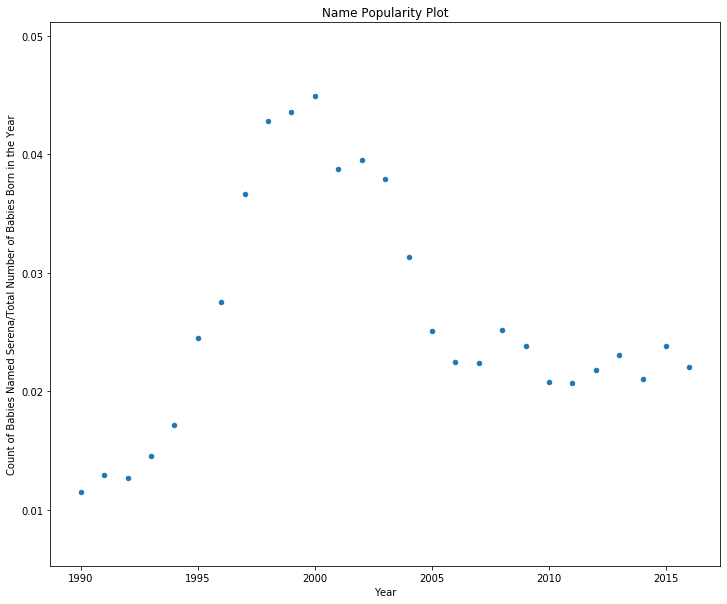

In [100]:
baby.NamePopularityPlotStory(name='Serena', yearRange=(1990,2017), state=None, sex='F')